In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import linearsolve as ls
from scipy.optimize import fsolve
%matplotlib inline

In [22]:
# 1. Input model parameters and print
rho = .9
sigma = 1
alpha = 0.33
delta = 0.025
beta = 0.98
phi = 1.5
eta = 1

parameters = pd.Series()
parameters['rho'] = rho
parameters['sigma'] = sigma
parameters['alpha'] = alpha
parameters['delta'] = delta
parameters['beta'] = beta
parameters['phi'] = phi
parameters['eta'] = eta

In [23]:
# 2. Compute the steady state equilibrium manually
A = 1
k = (alpha*A/(beta**-1+delta-1))**(1/(1-alpha))
def L_fun(l_val):
    
    return l_val**sigma*(1-l_val)**-eta - phi**-1*(A*k**alpha-delta*k)**-sigma*(1-alpha)*A*k**alpha
    

L = fsolve(L_fun,x0=0.3)[0]
# L = 1 / ( 1 + phi/(1-alpha)*((beta**-1 + (1-alpha)*delta -1)/(beta**-1+delta-1)))
K = L*(alpha*A/(beta**-1+delta-1))**(1/(1-alpha))
C = A*K**alpha*L**(1-alpha) - delta*K
Y = A*K**alpha*L**(1-alpha)
I = delta*K

print('A:',round(A,5))
print('L:',round(L,5))
print('K:',round(K,5))
print('Y:',round(Y,5))
print('I:',round(I,5))
print('C:',round(C,5))

A: 1
L: 0.3531
K: 6.81618
Y: 0.93791
I: 0.1704
C: 0.76751


In [24]:
L

0.35310140636565018

In [25]:
# 3. Define a function that evaluates the equilibrium conditions
def equilibrium_equations(variables_forward,variables_current,parameters):
    
    # Parameters 
    p = parameters
    
    # Variables
    fwd = variables_forward
    cur = variables_current
        
    # Resource constraint
    resource =  cur.a*cur.k**p.alpha*cur.l**(1-p.alpha) + (1-p.delta)*cur.k - fwd.k - cur.c
    
    # Exogenous tfp
    tfp_process = p.rho*np.log(cur.a) - np.log(fwd.a)
    
    # Euler equation
    euler = p.beta*(p.alpha*fwd.a*fwd.k**(p.alpha-1)*fwd.l**(1-p.alpha) + 1 - p.delta)*fwd.c**-p.sigma - cur.c**-p.sigma
    
    # Labor supply
    labor_supply = p.phi*(1-cur.l)**-p.eta - (1-p.alpha)*cur.a*cur.k**alpha *cur.l**(-p.alpha)*cur.c**-p.sigma
    
    # Production
    production = cur.a*cur.k**p.alpha*cur.l**(1-p.alpha) - cur.y
    
    # Capital evoluation
    capital_evolution = cur.i + (1-p.delta)*cur.k - fwd.k
    
    # Stack equilibrium conditions into a numpy array
    return np.array([
        resource,
        tfp_process,
        euler,
        labor_supply,
        production,
        capital_evolution
        ])

In [26]:
# 4. Initialize the model
model = ls.model(equations = equilibrium_equations,
                 nstates=2,
                 varNames=['a','k','c','y','i','l'],                   # Any order as long as the state variables are named first
                 shockNames=['eA','eK'],                 # Name a shock for each state variable *even if there is no corresponding shock in the model*
                 parameters = parameters)

guess = [A,K,C,Y,I,L]
model.compute_ss(guess)
model.approximate_and_solve()

print(model.ss)

a    1.000000
k    6.816183
c    0.767506
y    0.937910
i    0.170405
l    0.353101
dtype: float64


In [27]:
# 3. Define a function that evaluates the equilibrium conditions
def equilibrium_equations_consolidated(variables_forward,variables_current,parameters):
    
    # Parameters 
    p = parameters
    
    # Variables
    fwd = variables_forward
    cur = variables_current
            
    # Exogenous tfp
    tfp_process = p.rho*np.log(cur.a) - np.log(fwd.a)
    
#     Euler equation
    euler = p.beta*(1-fwd.l)**-p.eta*fwd.a**-1*fwd.k**-p.alpha*fwd.l**p.alpha*(p.alpha*fwd.a*fwd.k**(p.alpha-1)*fwd.l**(1-p.alpha)+1-p.delta)-(1-cur.l)**-p.eta*cur.a**-1*cur.k**-p.alpha*cur.l**p.alpha
#     euler = p.beta*(1-fwd.l)**-p.eta*cur.a**-p.rho*fwd.k**-p.alpha*fwd.l**p.alpha*(p.alpha*cur.a**p.rho*fwd.k**(p.alpha-1)*fwd.l**(1-p.alpha)+1-p.delta)-(1-cur.l)**-p.eta*cur.a**-1*cur.k**-p.alpha*cur.l**p.alpha
    
    # Labor supply
    resource = (p.phi/(1-p.alpha)*(1-cur.l)**-p.eta*cur.a**-1*cur.k**-p.alpha*cur.l**p.alpha)**(-1/p.sigma) + fwd.k - (1-p.delta)*cur.k - cur.a*cur.k**p.alpha*cur.l**(1-p.alpha)
    
#     # Output
#     output = cur.a*cur.k**p.alpha*cur.l**(1-p.alpha) - cur.y
    
#     # Investment
#     investment = fwd.k - (1-p.delta)*cur.k - cur.i
    
#     # Consumption
#     consumption = cur.y - cur.i - cur.c
        
    # Stack equilibrium conditions into a numpy array
    return np.array([
        tfp_process,
        euler,
        resource,
#         output,
#         investment,
#         consumption
        ])

In [28]:
# 4. Initialize the model
model_consolidated = ls.model(equations = equilibrium_equations_consolidated,
                 nstates=2,
#                  varNames=['a','k','c','y','i','l'], 
                 varNames=['a','k','l'],                   # Any order as long as the state variables are named first
                 shockNames=['eA','eK'],                 # Name a shock for each state variable *even if there is no corresponding shock in the model*
                 parameters = parameters)

guess = [A,K,L]
# guess = [A,K,C,Y,I,L]
model_consolidated.compute_ss(guess)
model_consolidated.approximate_and_solve()

print(model_consolidated.ss)

a    1.000000
k    6.816183
l    0.353101
dtype: float64


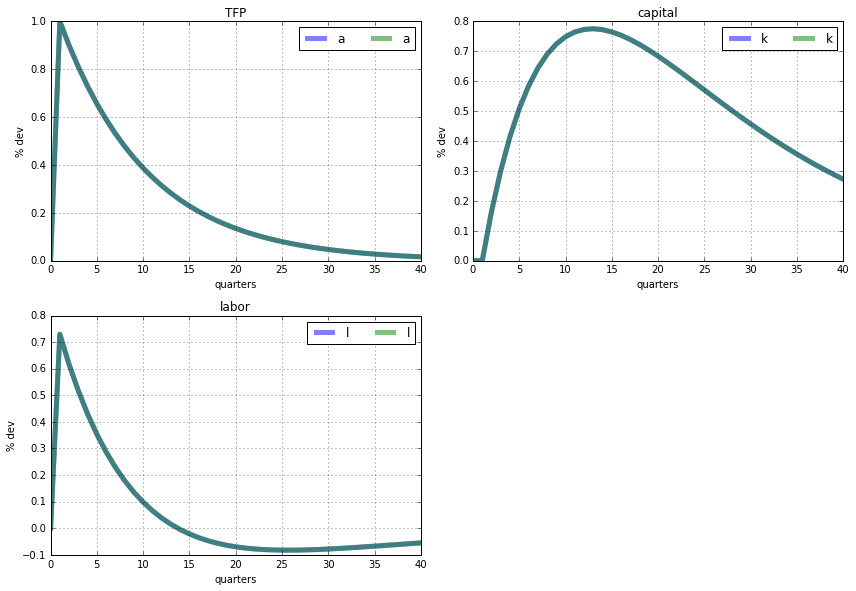

In [34]:
# 5(a) Compute impulse responses and print the computed impulse responses
model.impulse(T=41,t0=1,shock=None,percent=True)
model_consolidated.impulse(T=41,t0=1,shock=None,percent=True)

# 5(b) Plot the computed impulse responses to a TFP shock
fig = plt.figure(figsize=(12,12))

ax1 = fig.add_subplot(3,2,1)
model.irs['eA'][['a']].plot(lw=5,alpha=0.5,grid=True,ax = ax1).legend(loc='upper right',ncol=4)
model_consolidated.irs['eA'][['a']].plot(lw=5,alpha=0.5,grid=True,ax = ax1).legend(loc='upper right',ncol=4)
ax1.set_title('TFP')
ax1.set_ylabel('% dev')
ax1.set_xlabel('quarters')

ax2 = fig.add_subplot(3,2,2)
model.irs['eA'][['k']].plot(lw=5,alpha=0.5,grid=True,ax = ax2).legend(loc='upper right',ncol=2)
model_consolidated.irs['eA'][['k']].plot(lw=5,alpha=0.5,grid=True,ax = ax2).legend(loc='upper right',ncol=2)
ax2.set_title('capital')
ax2.set_ylabel('% dev')
ax2.set_xlabel('quarters')

ax3 = fig.add_subplot(3,2,3)
model.irs['eA'][['l']].plot(lw=5,alpha=0.5,grid=True,ax = ax3).legend(loc='upper right',ncol=4)
model_consolidated.irs['eA'][['l']].plot(lw=5,alpha=0.5,grid=True,ax = ax3).legend(loc='upper right',ncol=4)
ax3.set_title('labor')
ax3.set_ylabel('% dev')
ax3.set_xlabel('quarters')

# ax4 = fig.add_subplot(3,2,4)
# model.irs['eA'][['y']].plot(lw=5,alpha=0.5,grid=True,ax = ax4).legend(loc='upper right',ncol=4)
# model_consolidated.irs['eA'][['y']].plot(lw=5,alpha=0.5,grid=True,ax = ax4).legend(loc='upper right',ncol=4)
# ax4.set_title('output')
# ax4.set_ylabel('% dev')
# ax4.set_xlabel('quarters')

# ax5 = fig.add_subplot(3,2,5)
# model.irs['eA'][['i']].plot(lw=5,alpha=0.5,grid=True,ax = ax5).legend(loc='upper right',ncol=4)
# model_consolidated.irs['eA'][['i']].plot(lw=5,alpha=0.5,grid=True,ax = ax5).legend(loc='upper right',ncol=4)
# ax5.set_title('investment')
# ax5.set_ylabel('% dev')
# ax5.set_xlabel('quarters')


# ax6 = fig.add_subplot(3,2,6)
# model.irs['eA'][['c']].plot(lw=5,alpha=0.5,grid=True,ax = ax6).legend(loc='upper right',ncol=4)
# model_consolidated.irs['eA'][['c']].plot(lw=5,alpha=0.5,grid=True,ax = ax6).legend(loc='upper right',ncol=4)
# ax6.set_title('consumption')
# ax6.set_ylabel('% dev')
# ax6.set_xlabel('quarters')

plt.tight_layout()

In [45]:
model.irs['eA'][['i']]

,i
0,0.000000
1,6.568957
2,5.657518
3,4.853450
4,4.144981
5,3.521583
6,2.973842
7,2.493344
8,2.072569
9,1.704800


In [37]:
print(model.solved())

Solution to the log-linear system:

a[t+1] = 0.9·a[t]+eA[t+1]

k[t+1] = 0.1642·a[t]+0.9363·k[t]+eK[t+1]

  c[t] = 0.361·a[t]+0.5457·k[t]

  y[t] = 1.4889·a[t]+0.165·k[t]

  i[t] = 6.569·a[t]-1.55·k[t]

  l[t] = 0.7296·a[t]-0.2463·k[t]


In [10]:
# Compute the coefficients of the log-linearization

GAMMA  = (1-L)**-eta/A/K**alpha*L**alpha
PHI = sigma**-1*(phi/(1-alpha)*(1-L)**-eta*A**-1*K**-alpha*L**alpha)**(-1/sigma)

phi_01 = beta*GAMMA*(alpha*(delta-1)-alpha*Y/K)
phi_02 = beta*GAMMA*(eta*(1-L)**-1*L*(alpha*Y/K+1-delta) + alpha*Y/K + alpha*(1 - delta))
phi_03 = -alpha*GAMMA

phi_00 = beta*GAMMA*(delta-1)
phi_04_lhs = phi_00*rho
phi_04_rhs = -GAMMA

phi_04=-phi_04_lhs+phi_04_rhs
phi_05 = GAMMA*(eta*L/(1-L)+alpha)
phi_06 = K
phi_08 = alpha*Y + (1-delta)*K - PHI*alpha
phi_09 = Y - PHI
phi_10 = PHI*(eta*(1-L)**-1*L+alpha) + (1-alpha)*Y

In [11]:
print('GAMMA=',GAMMA)
print('PHI=',PHI)
print('phi_01=',phi_01)
print('phi_02=',phi_02)
print('phi_03=',phi_03)
print('phi_04=',phi_04)
print('phi_05=',phi_05)
print('phi_06=',phi_06)
print('phi_08=',phi_08)
print('phi_09=',phi_09)
print('phi_10=',phi_10)

GAMMA= 0.435162171228
PHI= 144.107609954
phi_01= -0.162135985473
phi_02= 0.380239559631
phi_03= -0.15230675993
phi_04= -0.0361238997391
phi_05= 0.370410334088
phi_06= 11.4844167166
phi_08= -38.837242558
phi_09= -142.955853876
phi_10= 123.413136383


In [12]:
gamma_03_poly_2 = phi_06**-1*phi_02*phi_10
gamma_03_poly_1 = phi_06**-1*(phi_01*phi_10+phi_02*phi_08)-phi_05
gamma_03_poly_0 = phi_06**-1*phi_01*phi_08-phi_03

gamma_03 = np.min(np.roots([gamma_03_poly_2,gamma_03_poly_1,gamma_03_poly_0]))
gamma_01 = phi_06**-1*(phi_08+phi_10*gamma_03)

a = phi_04-phi_06**-1*(phi_02*gamma_03*phi_09 + phi_01*phi_09)
b = phi_06**-1*(phi_01*phi_10+phi_02*gamma_03*phi_10)+phi_02*rho-phi_05 

gamma_04 = (phi_04-phi_06**-1*(phi_02*gamma_03*phi_09 + phi_01*phi_09))/(phi_06**-1*(phi_01*phi_10+phi_02*gamma_03*phi_10)+phi_02*rho-phi_05 )
gamma_02 = phi_06**-1*(phi_09+phi_10*gamma_04)

In [13]:
print(gamma_01,gamma_02,gamma_03,gamma_04)

0.672408825343 1.30439233362 0.377265071422 1.27973442395


In [14]:
print(model_consolidated.solved())

Solution to the log-linear system:

a[t+1] = 0.95·a[t]+eA[t+1]

k[t+1] = 1.3044·a[t]+0.6724·k[t]+eK[t+1]

  l[t] = 1.2797·a[t]+0.3773·k[t]


In [15]:
def myfun(x):
    
    PSI_01, PSI_02, PSI_03, PSI_04 = x
    
    retval = np.zeros(4)
    
    retval[0] = phi_01*PSI_01+phi_02*PSI_03*PSI_01 - phi_03-phi_05*PSI_03
    retval[1] = phi_01*PSI_02+phi_02*(PSI_03*PSI_02+PSI_04*rho)- phi_04-phi_05*PSI_04
    retval[2] = phi_06*PSI_01-phi_08-phi_10*PSI_03
    retval[3] = phi_06*PSI_02-phi_09-phi_10*PSI_04
    
    return retval
    

In [16]:
PSI_01, PSI_02, PSI_03, PSI_04 = fsolve(myfun,x0=[1,1,1,1])
print('PSI_01',PSI_01, '\nPSI_02',PSI_02, '\nPSI_03',PSI_03, '\nPSI_04',PSI_04)

PSI_01 0.672408825332 
PSI_02 1.30439233357 
PSI_03 0.377265071421 
PSI_04 1.27973442394


In [17]:
print(np.isclose(PSI_01,psi_01))
print(np.isclose(PSI_02,psi_02))
print(np.isclose(PSI_03,psi_03))
print(np.isclose(PSI_04,psi_04))

NameError: name 'psi_01' is not defined

In [ ]:
print(np.isclose(psi_04,np.array(model_consolidated.f)[0][0]))
print(np.isclose(psi_03,np.array(model_consolidated.f)[0][1]))
print(np.isclose(psi_01,np.array(model_consolidated.p)[1][1]))
print(np.isclose(psi_02,np.array(model_consolidated.p)[1][0]))

In [ ]:
# 5(a) Compute impulse responses and print the computed impulse responses
model.impulse(T=41,t0=5,shock=None,percent=True)

# 5(b) Plot the computed impulse responses to a TFP shock
fig = plt.figure(figsize=(12,12))

ax1 = fig.add_subplot(3,2,1)
model.irs['eA'][['y']].plot(lw=5,alpha=0.5,grid=True,ax = ax1).legend(loc='upper right',ncol=4)
ax1.set_title('Output, investment, capital')
ax1.set_ylabel('% dev')
ax1.set_xlabel('quarters')

ax2 = fig.add_subplot(3,2,2)
model.irs['eA'][['a','eA']].plot(lw=5,alpha=0.5,grid=True,ax = ax2).legend(loc='upper right',ncol=2)
ax2.set_title('TFP and TFP shock')
ax2.set_ylabel('% dev')
ax2.set_xlabel('quarters')

ax3 = fig.add_subplot(3,2,3)
model.irs['eA'][['l']].plot(lw=5,alpha=0.5,grid=True,ax = ax3).legend(loc='upper right',ncol=4)
ax3.set_title('Output, consumption, and labor')
ax3.set_ylabel('% dev')
ax3.set_xlabel('quarters')

plt.tight_layout()

In [ ]:
# 6(a) Compute stochastic simulation and print the simulated values
model.stoch_sim(seed=192,covMat= [[parameters['sigma']**2,0],[0,0]])

# 6(b) Plot the computed stochastic simulation
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(1,2,1)
model.simulated[['k','c','y','i','l']].plot(lw=5,alpha=0.5,grid=True,ax = ax1).legend(ncol=5,bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand")

ax2 = fig.add_subplot(1,2,2)
model.simulated[['eA','a']].plot(lw=5,alpha=0.5,grid=True,ax = ax2).legend(ncol=2,bbox_to_anchor=(0., 1.02, 1., .102), loc=3)